In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model

Using TensorFlow backend.
D:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as

In [67]:
april = pd.read_csv('uber-raw-data-apr14.csv')
may   = pd.read_csv('uber-raw-data-may14.csv')
june  = pd.read_csv('uber-raw-data-jun14.csv')
july  = pd.read_csv('uber-raw-data-jul14.csv')
aug   = pd.read_csv('uber-raw-data-aug14.csv')
sept  = pd.read_csv('uber-raw-data-sep14.csv')

In [68]:
april.shape

(564516, 4)

In [69]:
data =  april.append(may).append(june).append(july).append(aug).append(sept)

In [70]:
data

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512
...,...,...,...,...
1028131,9/30/2014 22:57:00,40.7668,-73.9845,B02764
1028132,9/30/2014 22:57:00,40.6911,-74.1773,B02764
1028133,9/30/2014 22:58:00,40.8519,-73.9319,B02764
1028134,9/30/2014 22:58:00,40.7081,-74.0066,B02764


In [71]:

data.Timestamp = pd.to_datetime(data['Date/Time'],format='%m/%d/%Y %H:%M:%S')

D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [72]:
data['date_only'] = data.Timestamp.dt.date
data['date'] = data.Timestamp
data['month'] = data.Timestamp.dt.month
data['dow_num'] = data.Timestamp.dt.dayofweek
data['dow_name'] = data.Timestamp.dt.day_name()
data['month_day_num'] = data.Timestamp.dt.day
data['hours'] = data.Timestamp.dt.hour


In [73]:
data

,Date/Time,Lat,Lon,Base,date_only,date,month,dow_num,dow_name,month_day_num,hours
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,2014-04-01,2014-04-01 00:11:00,4,1,Tuesday,1,0
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512,2014-04-01,2014-04-01 00:17:00,4,1,Tuesday,1,0
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512,2014-04-01,2014-04-01 00:21:00,4,1,Tuesday,1,0
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512,2014-04-01,2014-04-01 00:28:00,4,1,Tuesday,1,0
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512,2014-04-01,2014-04-01 00:33:00,4,1,Tuesday,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1028131,9/30/2014 22:57:00,40.7668,-73.9845,B02764,2014-09-30,2014-09-30 22:57:00,9,1,Tuesday,30,22
1028132,9/30/2014 22:57:00,40.6911,-74.1773,B02764,2014-09-30,2014-09-30 22:57:00,9,1,Tuesday,30,22
1028133,9/30/2014 22:58:00,40.8519,-73.9319,B02764,2014-09-30,2014-09-30 22:58:00,9,1,Tuesday,30,22
1028134,9/30/2014 22:58:00,40.7081,-74.0066,B02764,2014-09-30,2014-09-30 22:58:00,9,1,Tuesday,30,22


In [74]:
data['Base'].value_counts()

B02617    1458853
B02598    1393113
B02682    1212789
B02764     263899
B02512     205673
Name: Base, dtype: int64

In [75]:
data.groupby('hours')['hours'].count().sort_values(ascending=False)


hours
17    336190
18    324679
16    313400
19    294513
20    284604
21    281460
15    275466
22    241858
14    230625
13    195877
7     193094
8     190504
12    170452
23    169190
11    165703
9     159967
10    159148
6     143213
0     103836
5      83939
1      67227
4      55230
3      48287
2      45865
Name: hours, dtype: int64

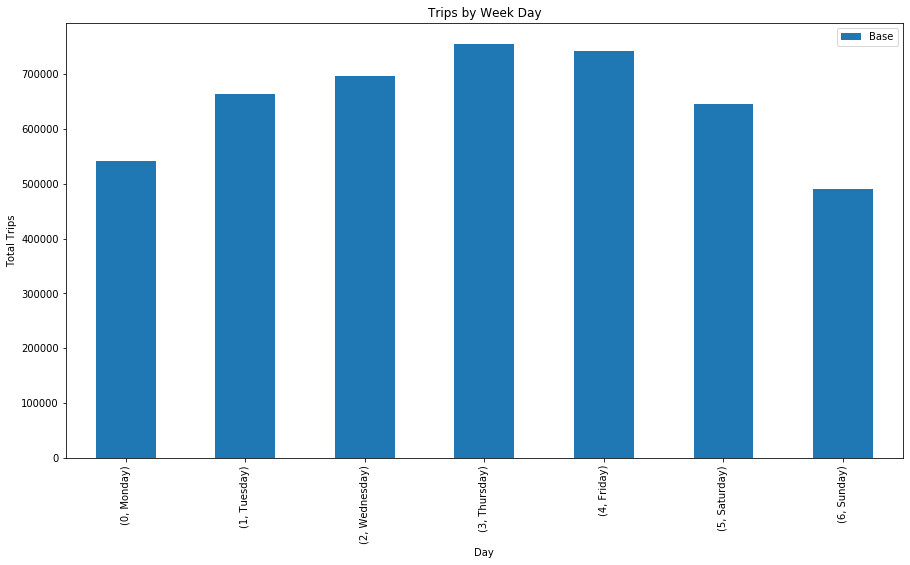

In [76]:
## peak days

data.groupby(pd.Grouper(key='dow_name')).count()

uber_weekdays = data.pivot_table(index=['dow_num','dow_name'],values='Base', aggfunc='count')
uber_weekdays.plot(kind='bar', figsize=(15,8))
plt.ylabel('Total Trips')
plt.xlabel('Day')
plt.title('Trips by Week Day');


we can see ,there are more trips on thursdays and fridays

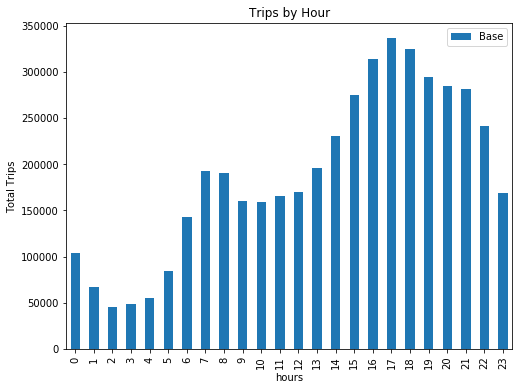

In [77]:
## peak hours 

uber_hour = data.pivot_table(index=['hours'], values='Base', aggfunc='count')
uber_hour.plot(kind='bar', figsize=(8,6))
plt.ylabel('Total Trips')
plt.title('Trips by Hour');

we can observe that more people take ride in the evening around 5pm

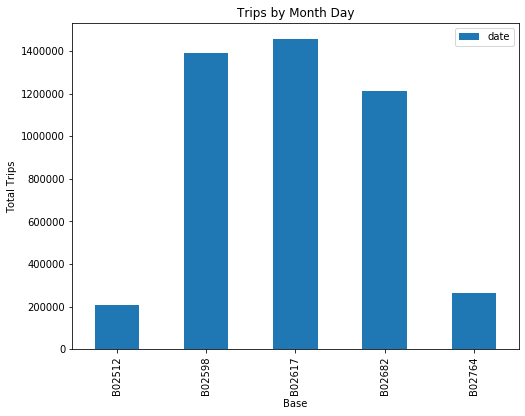

In [78]:
data.groupby(pd.Grouper(key='Base')).count()

uber_monthdays = data.pivot_table(index=['Base'], values='date' ,
                                  aggfunc='count')
uber_monthdays.plot(kind='bar', figsize=(8,6))
plt.ylabel('Total Trips')
plt.title('Trips by Month Day');

## Splitting data

In [79]:
data.drop(['Lat','Lon'],axis=1,inplace=True)

In [80]:
data

,Date/Time,Base,date_only,date,month,dow_num,dow_name,month_day_num,hours
0,4/1/2014 0:11:00,B02512,2014-04-01,2014-04-01 00:11:00,4,1,Tuesday,1,0
1,4/1/2014 0:17:00,B02512,2014-04-01,2014-04-01 00:17:00,4,1,Tuesday,1,0
2,4/1/2014 0:21:00,B02512,2014-04-01,2014-04-01 00:21:00,4,1,Tuesday,1,0
3,4/1/2014 0:28:00,B02512,2014-04-01,2014-04-01 00:28:00,4,1,Tuesday,1,0
4,4/1/2014 0:33:00,B02512,2014-04-01,2014-04-01 00:33:00,4,1,Tuesday,1,0
...,...,...,...,...,...,...,...,...,...
1028131,9/30/2014 22:57:00,B02764,2014-09-30,2014-09-30 22:57:00,9,1,Tuesday,30,22
1028132,9/30/2014 22:57:00,B02764,2014-09-30,2014-09-30 22:57:00,9,1,Tuesday,30,22
1028133,9/30/2014 22:58:00,B02764,2014-09-30,2014-09-30 22:58:00,9,1,Tuesday,30,22
1028134,9/30/2014 22:58:00,B02764,2014-09-30,2014-09-30 22:58:00,9,1,Tuesday,30,22


In [81]:
x = data.groupby('date_only').count()

In [82]:
x_tsf = x.copy()

all the columns have same value , because we jut counted number of trips for day . so the quantities are same for all <br/>
Let's delete all the columns keeping one

In [83]:
x_tsf.drop(['Date/Time','Base','month','dow_num','dow_name','month_day_num','hours'],axis=1,inplace=True)

In [84]:
x_tsf

,date
date_only,
2014-04-01,14546
2014-04-02,17474
2014-04-03,20701
2014-04-04,26714
2014-04-05,19521
...,...
2014-09-26,37504
2014-09-27,39468
2014-09-28,29656


In [87]:
round(0.9*len(x_tsf))

165

In [88]:
train_ts = x[:][:165]                     #split is 90-10
test_ts = x[:][166:]
#test_ts_d = uber_dates_d[:][166:]

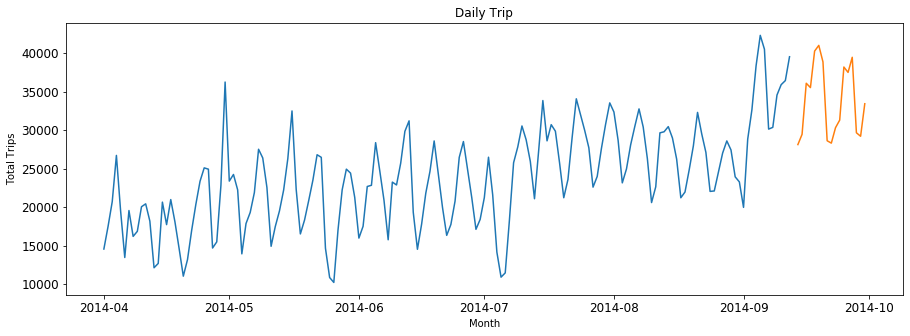

In [91]:
train_ts['date'].plot(kind='line',figsize=(15,8), title= 'Daily Trip', fontsize=12)
test_ts['date'].plot(figsize=(15,5), title= 'Daily Trip', fontsize=12)
plt.ylabel('Total Trips')
plt.xlabel('Month')
plt.show()

## Holt's winter seasonal method

In [95]:
hat_avg = test_ts.copy()
fit1 = ExponentialSmoothing(np.asarray(train_ts['date']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
hat_avg['Holt_Winter'] = fit1.forecast(len(test_ts))

D:\anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
D:\anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


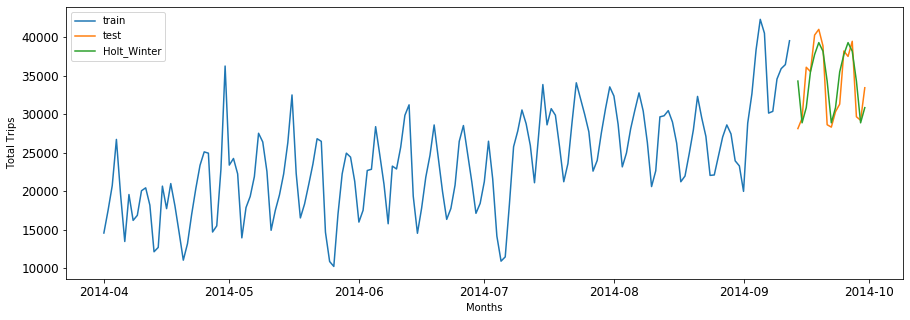

In [96]:
plt.figure(figsize=(15,5))
train_ts['date'].plot(kind='line',figsize=(15,8),fontsize=12,label='train')
test_ts['date'].plot(figsize=(15,5),fontsize=12,label='test')
plt.plot(hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.ylabel('Total Trips')
plt.xlabel('Months')
plt.show()

D:\anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 1600x800 with 0 Axes>

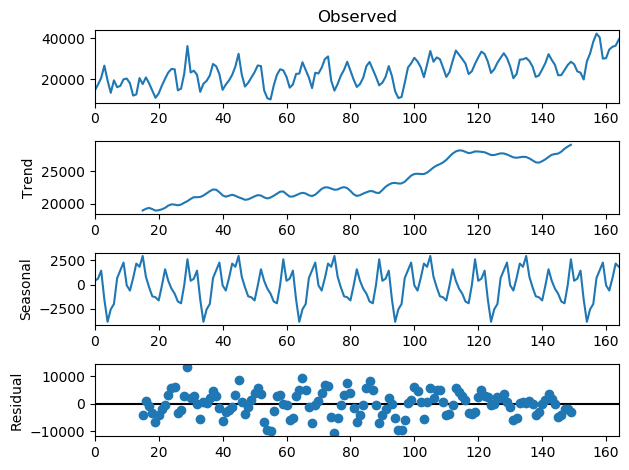

In [99]:

plt.style.use('default')
plt.figure(figsize = (16,8))
sm.tsa.seasonal_decompose(train_ts['date'].values,freq=30).plot()
result = sm.tsa.stattools.adfuller(x_tsf['date'])
plt.show()

In [100]:
hat_avg_1 = test_ts.copy()

fit1 = Holt(np.asarray(train_ts['date'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
hat_avg_1['Holt_linear'] = fit1.forecast(len(test_ts))

D:\anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


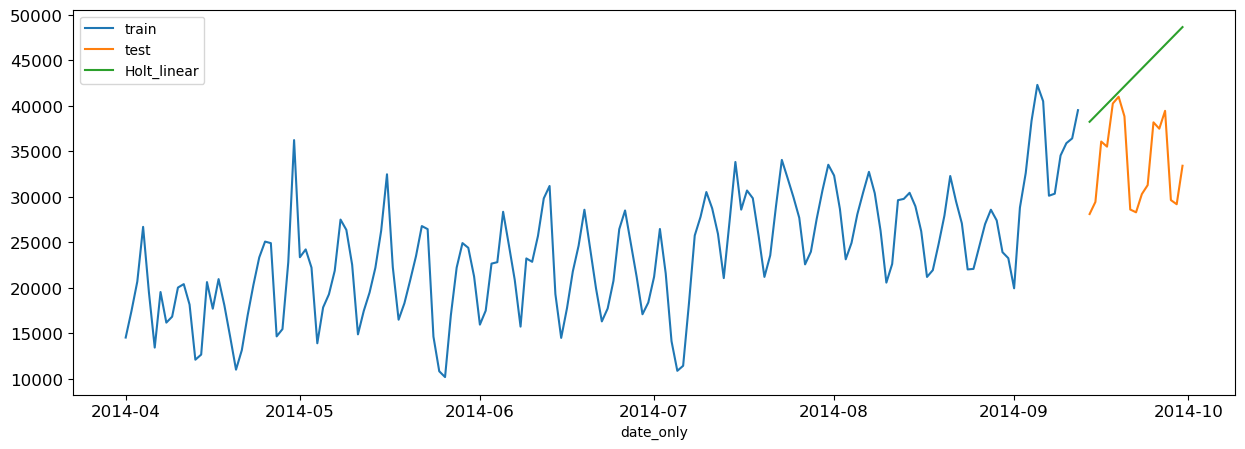

In [101]:
plt.figure(figsize=(16,5))
train_ts['date'].plot(kind='line',figsize=(15,8),fontsize=12,label='train')
test_ts['date'].plot(figsize=(15,5),fontsize=12,label='test')
plt.plot(hat_avg_1['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()


##  ARIMA

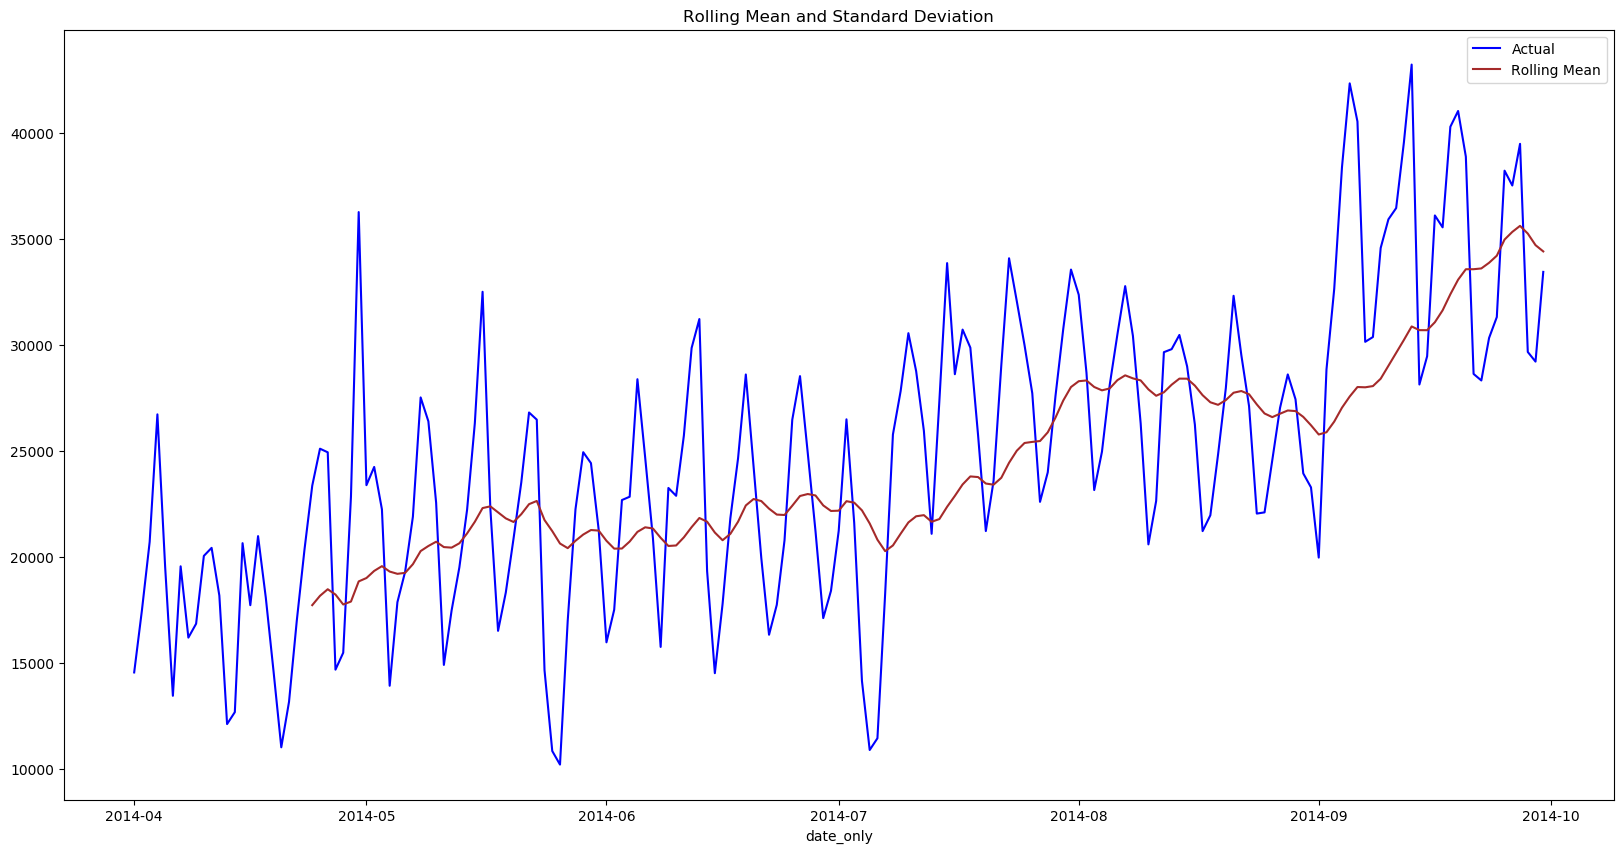

In [104]:
rcParams['figure.figsize']=(20,10)
rolmean = x_tsf['date'].rolling(24).mean()
rolstd = x_tsf['date'].rolling(24).std()
        
#Plot rolling Statistics
x_tsf['date'].plot(kind='line', color = "blue", label = "Actual")
rolmean.plot(kind='line', color = "brown", label = "Rolling Mean")
#.plot(kind='line', color = "black", label = "Rolling Std")
plt.legend(loc = "best")
plt.title("Rolling Mean and Standard Deviation")
plt.show(block = False)

In [105]:

Train_log = np.log(train_ts['date'])
valid_log = np.log(test_ts['date'])

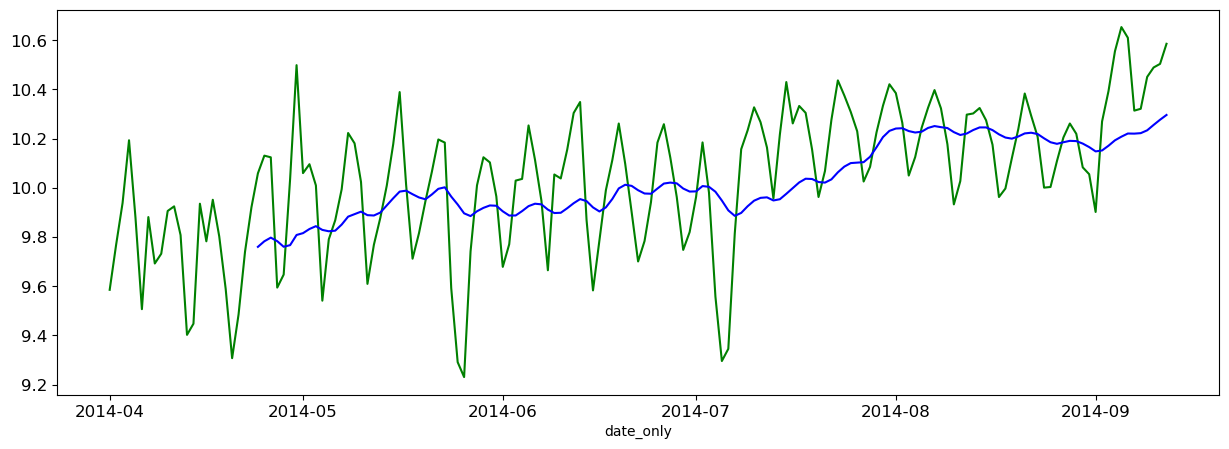

In [106]:
moving_avg = Train_log.rolling(24).mean()
Train_log.plot(kind='line',figsize=(15,8),fontsize=12, color = 'green', label='Training_log')
moving_avg.plot(figsize=(15,5),fontsize=12, color = 'blue', label='Moving_avg')


In [107]:

train_log_moving_diff = Train_log - moving_avg
train_log_moving_diff.dropna(inplace = True)

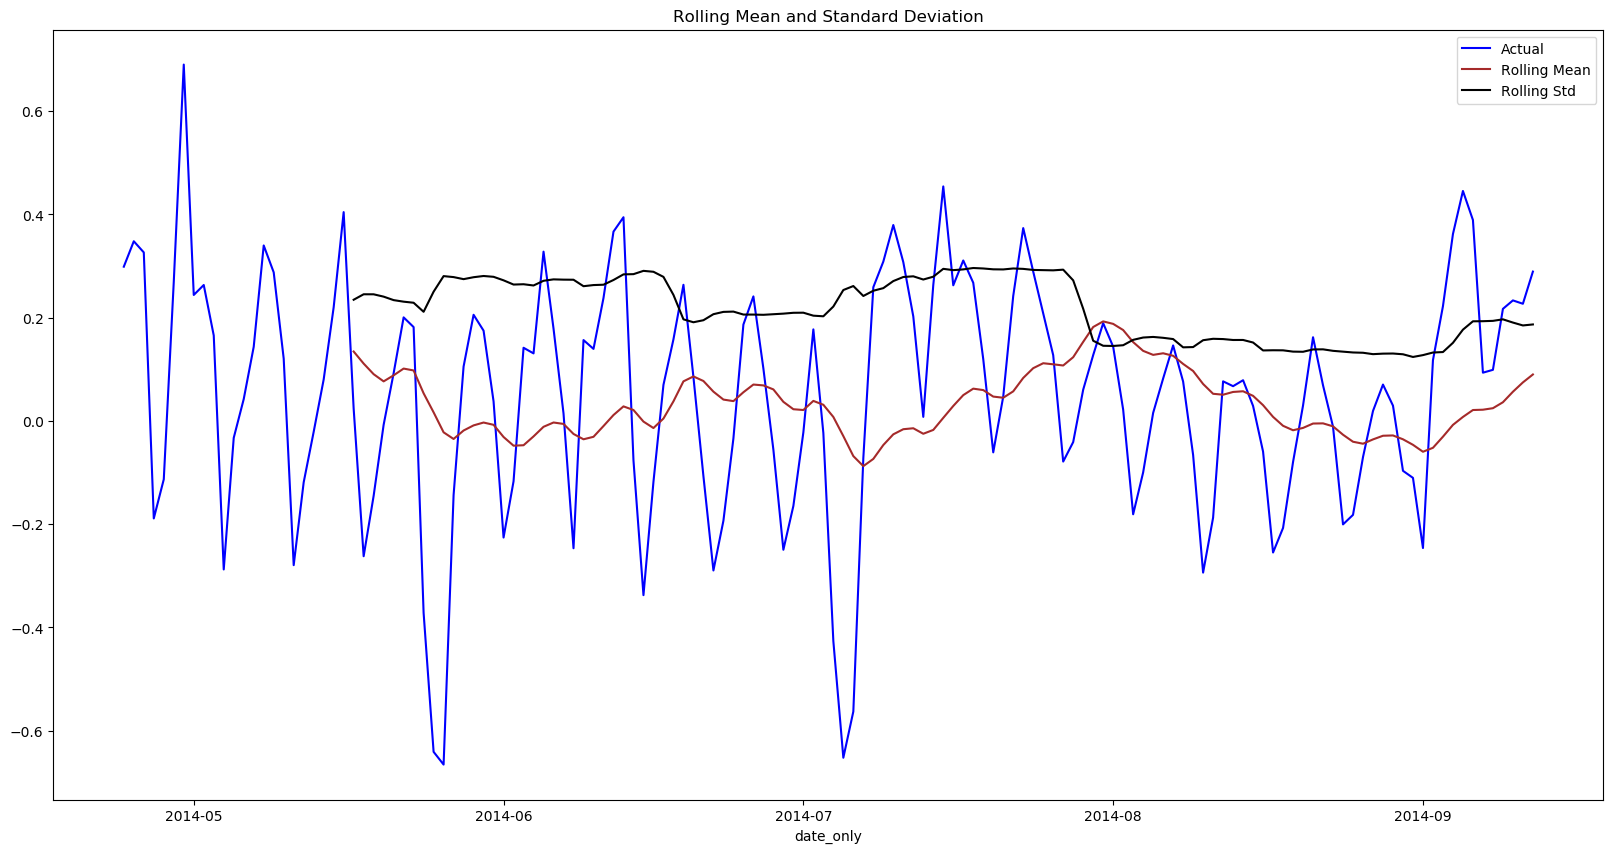

In [108]:

rolmean = train_log_moving_diff.rolling(24).mean()
rolstd = train_log_moving_diff.rolling(24).std()

#Plot rolling Statistics
train_log_moving_diff.plot(kind='line', color = "blue", label = "Actual")
rolmean.plot(kind='line', color = "brown", label = "Rolling Mean")
rolstd.plot(kind='line', color = "black", label = "Rolling Std")
plt.legend(loc = "best")
plt.title("Rolling Mean and Standard Deviation")
plt.show(block = False)

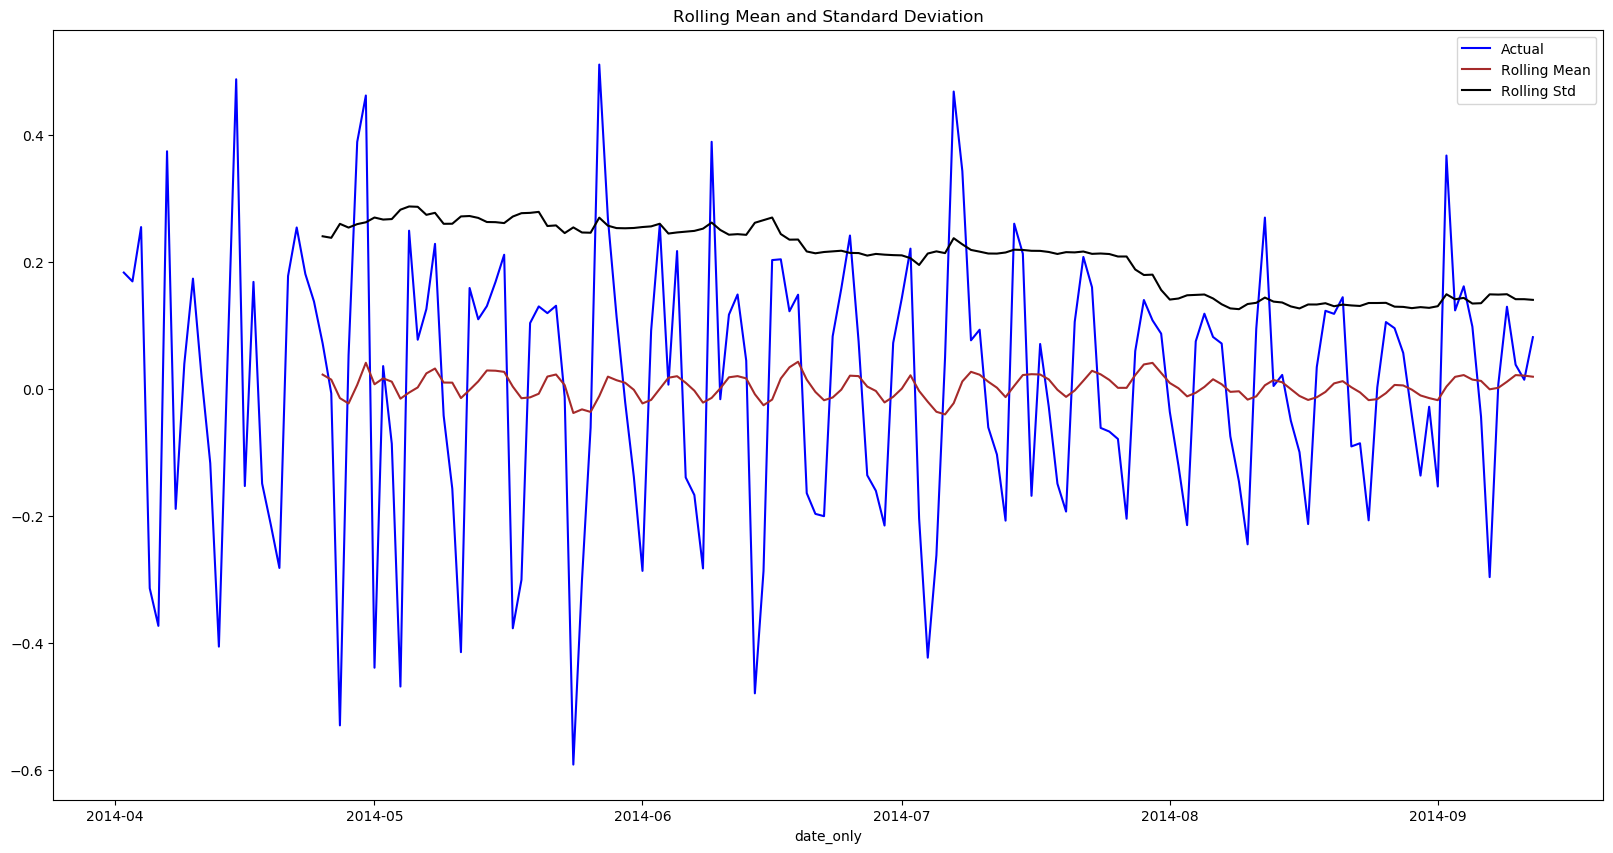

In [109]:
train_log_diff = Train_log - Train_log.shift(1)


rolmean = train_log_diff.rolling(24).mean()
rolstd = train_log_diff.rolling(24).std()

#Plot rolling Statistics
train_log_diff.plot(kind='line', color = "blue", label = "Actual")
rolmean.plot(kind='line', color = "brown", label = "Rolling Mean")
rolstd.plot(kind='line', color = "black", label = "Rolling Std")
plt.legend(loc = "best")
plt.title("Rolling Mean and Standard Deviation")
plt.show(block = False)

In [111]:
decomposition = seasonal_decompose(pd.DataFrame(Train_log)['date'].values, freq = 24)
plt.style.use('default')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


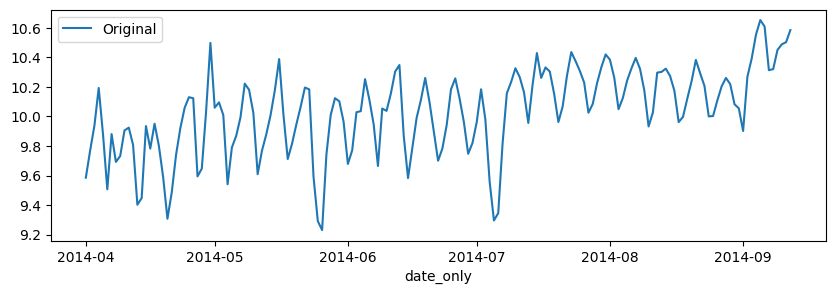

In [112]:
plt.figure(figsize = (10,3))
Train_log.plot(kind='line', label = 'Original')
plt.legend(loc = 'best')

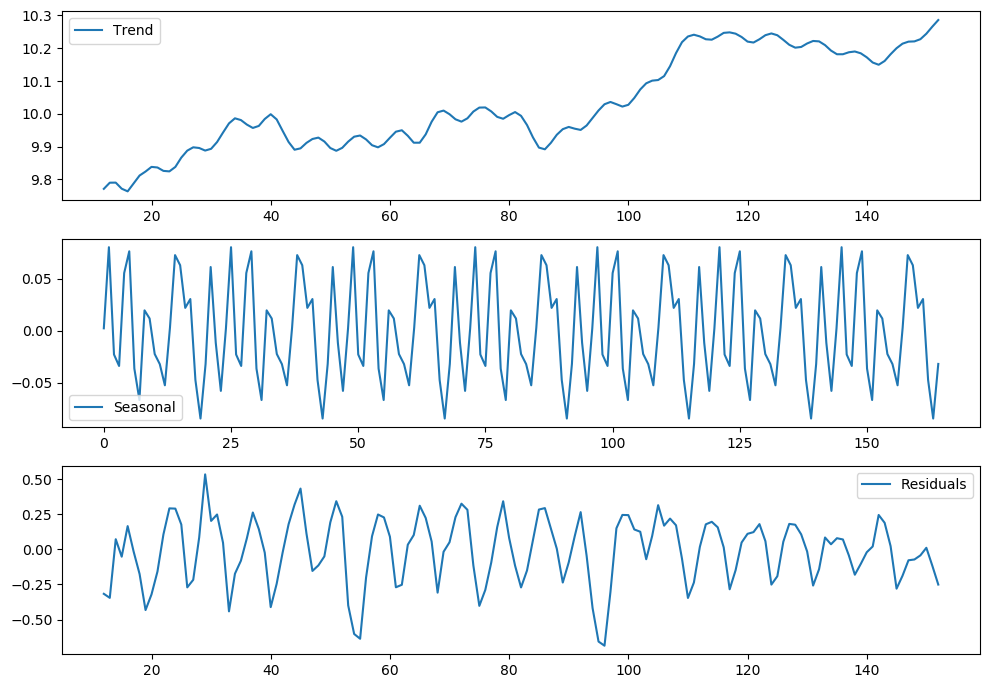

In [113]:
plt.figure(figsize = (10,9))
plt.subplot(411)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

In [114]:
train_log_decompose = pd.DataFrame(residual)
train_log_decompose['date'] = Train_log.index
train_log_decompose.set_index('date', inplace = True)
train_log_decompose.dropna(inplace = True)

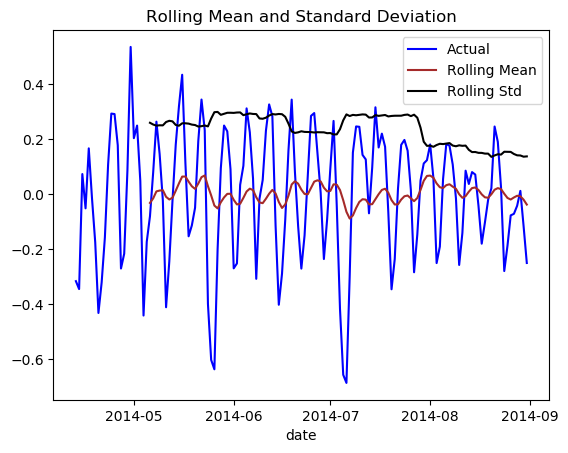

In [115]:
rolmean = train_log_decompose[0].rolling(24).mean()
rolstd = train_log_decompose[0].rolling(24).std()

#Plot rolling Statistics
train_log_decompose[0].plot(kind='line', color = "blue", label = "Actual")
rolmean.plot(kind='line', color = "brown", label = "Rolling Mean")
rolstd.plot(kind='line', color = "black", label = "Rolling Std")
plt.legend(loc = "best")
plt.title("Rolling Mean and Standard Deviation")
plt.show(block = False)


In [116]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(train_log_diff.dropna(), nlags = 25)
lag_pacf = pacf(train_log_diff.dropna(), nlags = 25, method= "ols")

D:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


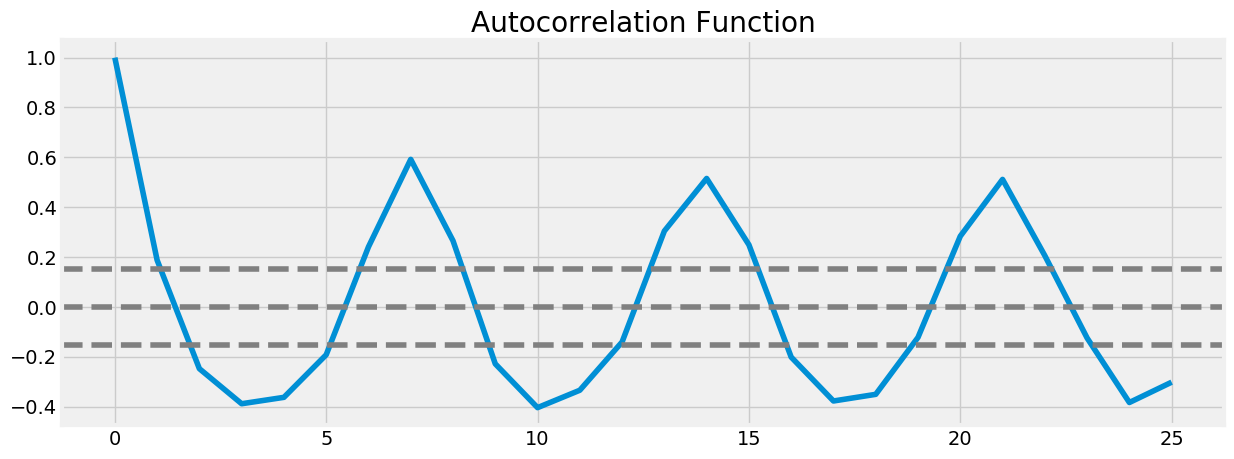

In [118]:
# ACF
plt.figure(figsize = (15,5))
plt.style.use("fivethirtyeight")
plt.plot(lag_acf)
plt.axhline( y = 0, linestyle = "--", color = "gray")
plt.axhline( y= -1.96/np.sqrt(len(train_log_diff.dropna())), linestyle = "--", color = "gray")
plt.axhline(y = 1.96 /np.sqrt(len(train_log_diff.dropna())), linestyle = "--", color = "gray")
plt.title("Autocorrelation Function")
plt.show()

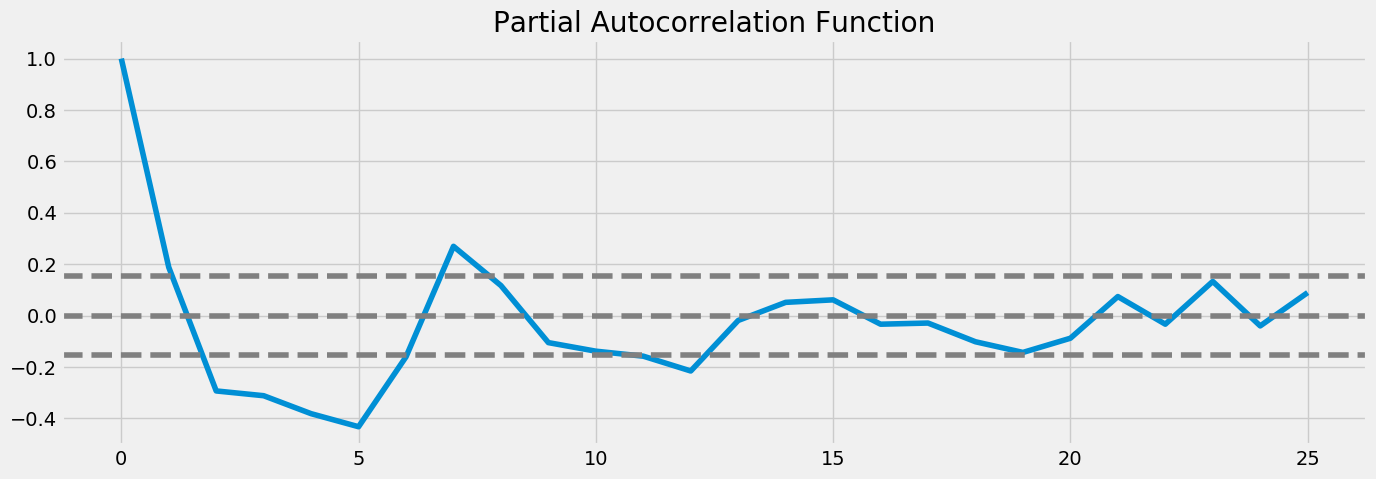

In [119]:
# PACF
plt.figure(figsize = (15,5))
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = "--", color = "gray")
plt.axhline(y = -1.96/np.sqrt(len(train_log_diff.dropna())), linestyle = "--", color = "gray")
plt.axhline( y = 1.96/np.sqrt(len(train_log_diff.dropna())), linestyle = "--", color = "gray")
plt.title("Partial Autocorrelation Function")
plt.show()


## AR Model

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


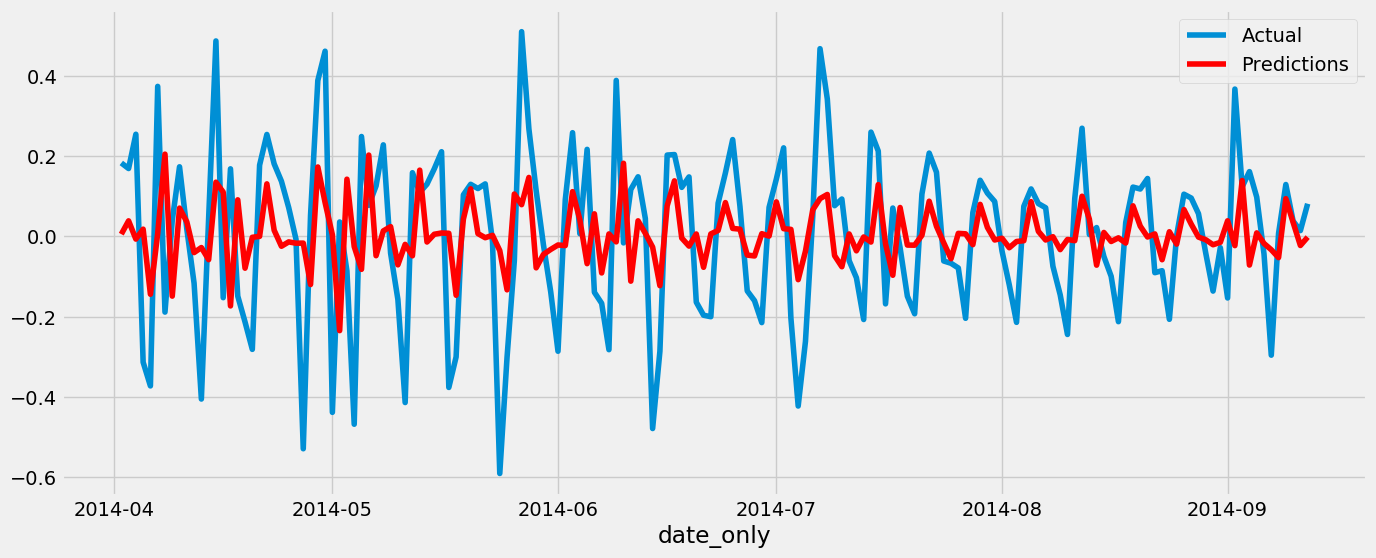

In [120]:

plt.figure(figsize = (15,6))
model = ARIMA(Train_log, order = (2,1,0))  #here q value is zero since it is just AR Model
results_AR = model.fit(disp=-1)
train_log_diff.dropna().plot(kind='line', label = "Actual")
results_AR.fittedvalues.plot(kind='line', color = 'red', label = 'Predictions')
plt.legend(loc = 'upper right')

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


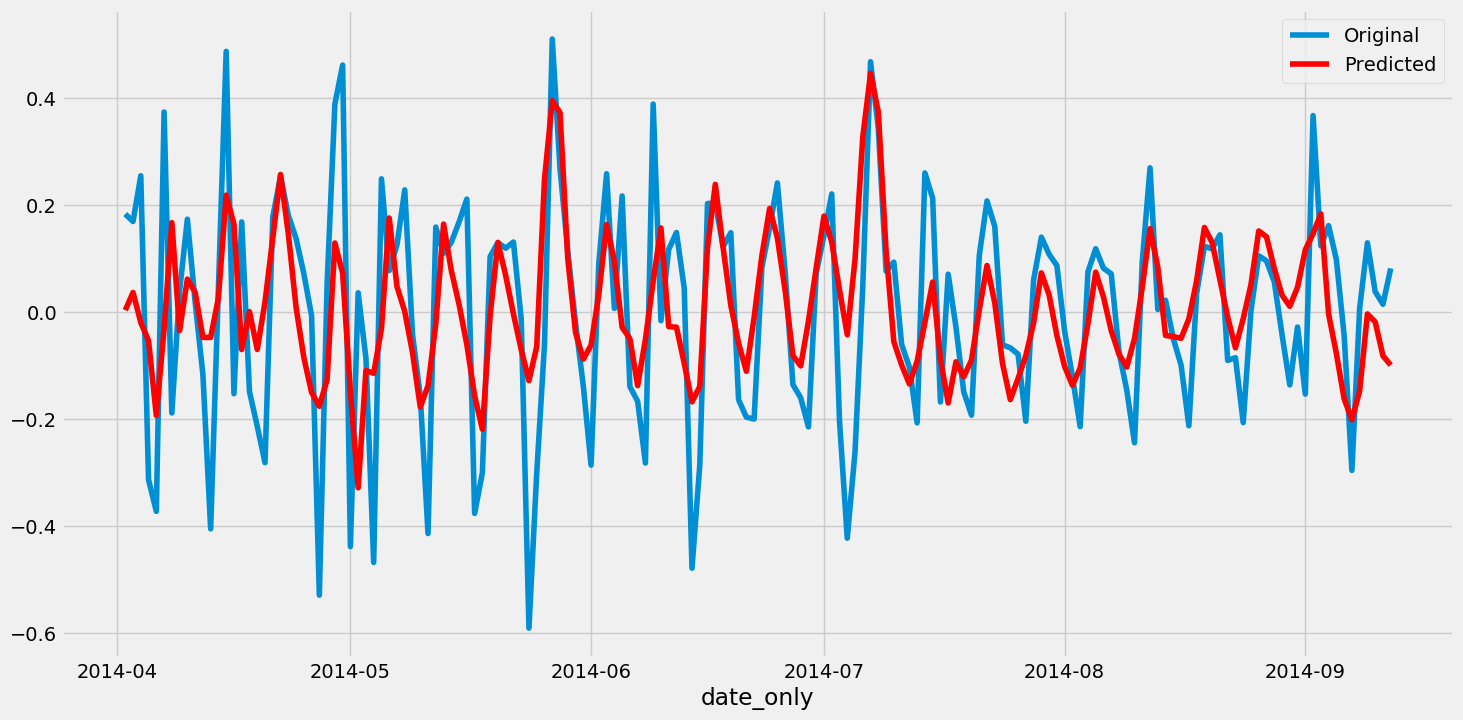

In [121]:

plt.figure(figsize = (16,8))
model = ARIMA(Train_log, order = (2,1,1))
results_ARIMA = model.fit(disp=-1)
train_log_diff.dropna().plot(kind='line',  label='Original')
results_ARIMA.fittedvalues.plot(kind='line', color='red', label='Predicted')
plt.legend(loc='best')
plt.show()

 ### to scale into original scale

In [129]:

def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['date'])[0], index = given_set.index)
    #predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_base)
    
    plt.plot(given_set['date'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['date']))/given_set.shape[0]))
    plt.show()

In [130]:
def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
    
    plt.plot(given_set['date'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['date']))/given_set.shape[0]))
    plt.show()

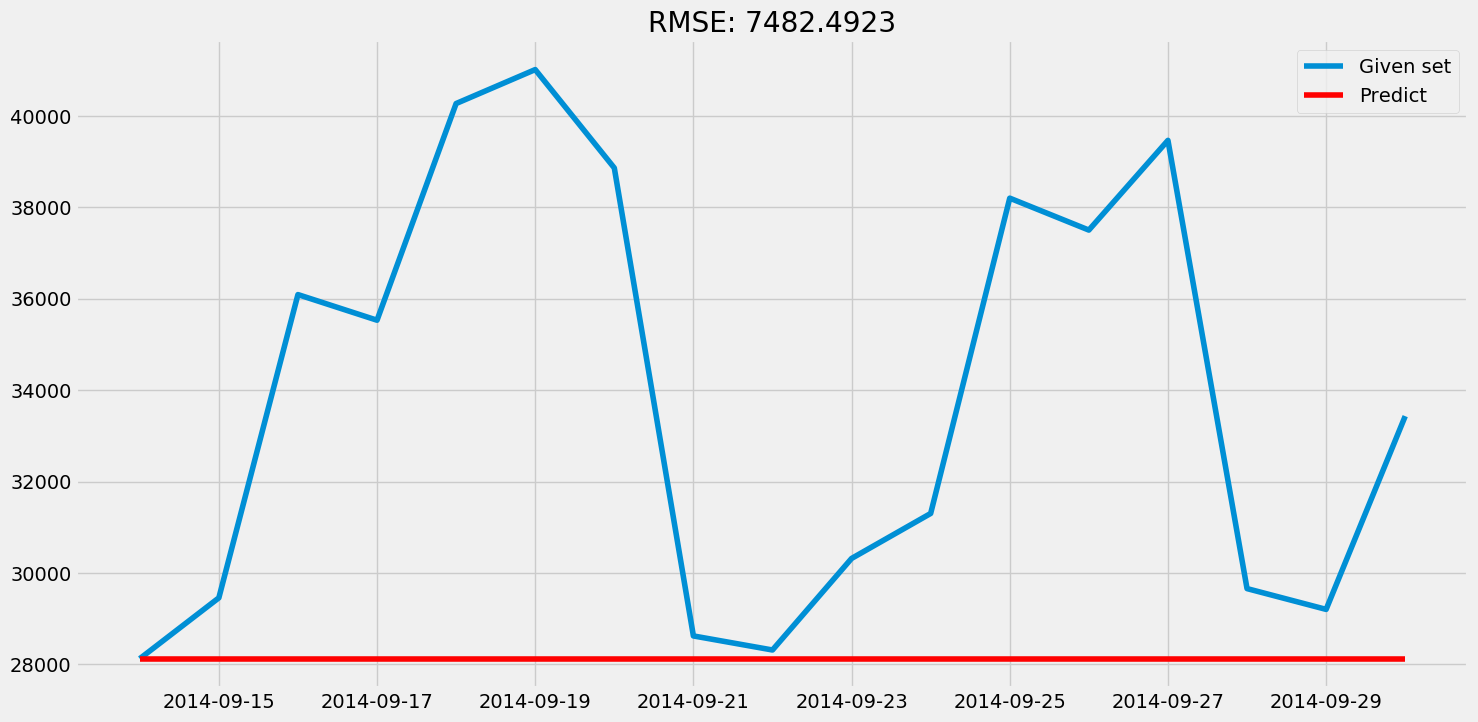

In [131]:
ARIMA_predict_diff=results_ARIMA.predict(len(train_ts))
plt.figure(figsize = (16,8))
check_prediction_diff(ARIMA_predict_diff, test_ts)

RMSE more, should go for any other model 

## Exponential smoothening

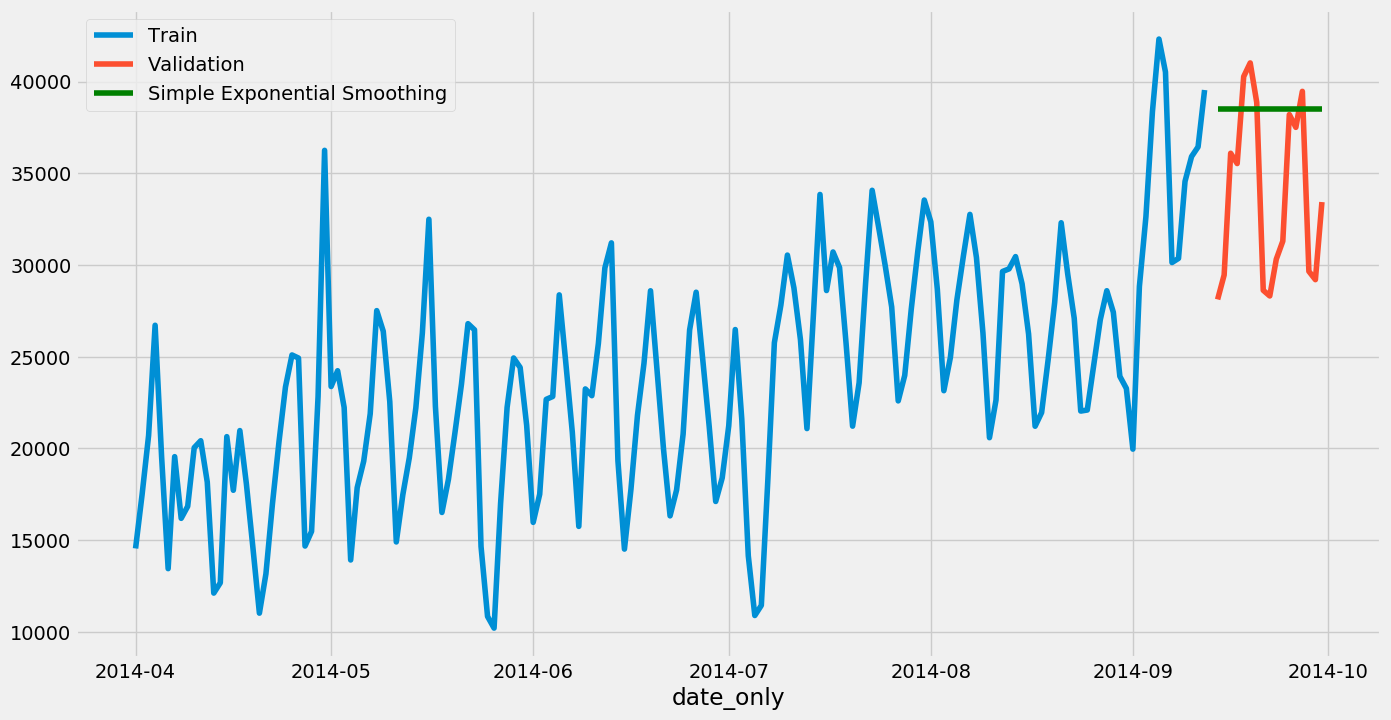

In [133]:
hat_avg = test_ts.copy()
fit2 = SimpleExpSmoothing(np.asarray(train_ts['date'])).fit(smoothing_level = 0.7,optimized = False)
hat_avg['SES'] = fit2.forecast(len(test_ts))
plt.figure(figsize =(15,8))
train_ts['date'].plot(kind='line',figsize=(15,8), label = 'Train')
test_ts['date'].plot(kind='line', label = 'Validation')
plt.plot(hat_avg['SES'], label = 'Simple Exponential Smoothing',color='green')
plt.legend(loc = 'best')

In [141]:
hat=hat_avg['SES'].values.tolist()
rmse = np.sqrt(mean_squared_error(test_ts['date'],hat))
rmse

6535.680208468773

better than AR model

## MA forecast with 10 observations

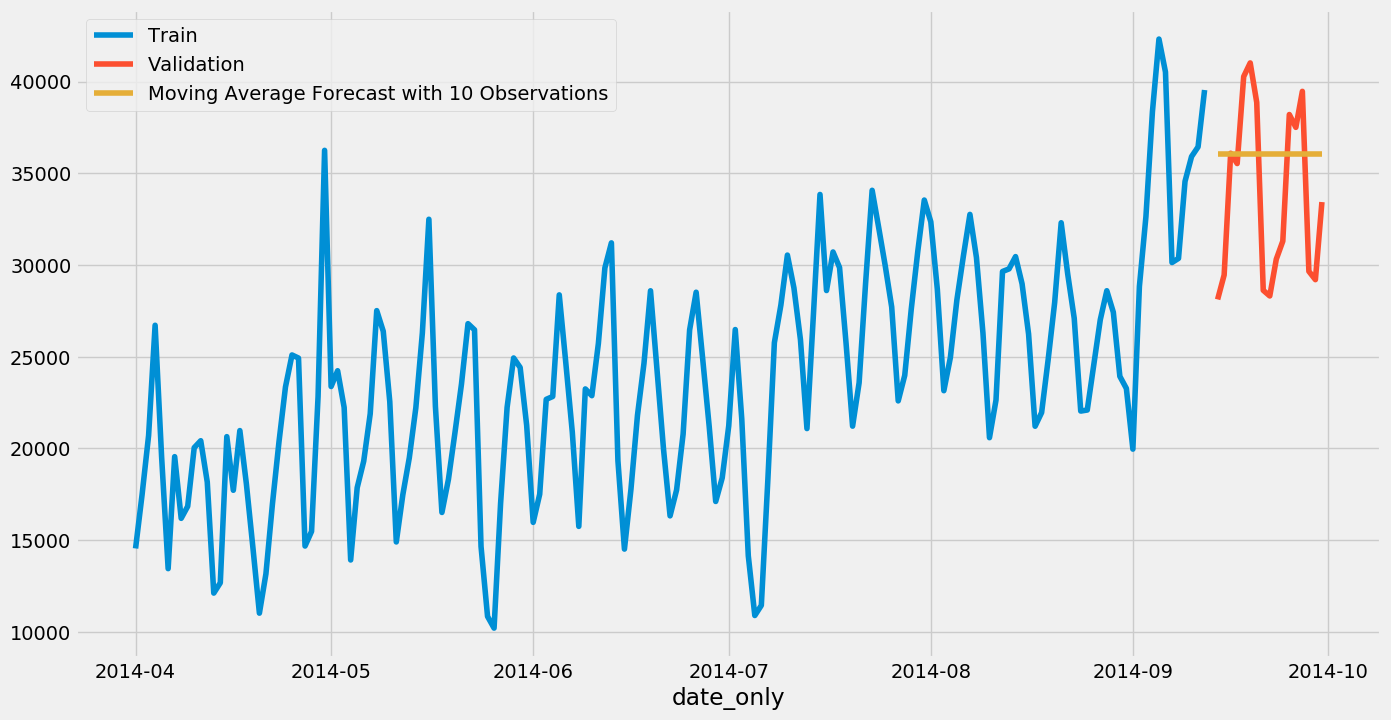

In [144]:

hat_avg = test_ts.copy()
hat_avg['moving_average_forecast'] = train_ts['date'].rolling(10).mean().iloc[-1]
plt.figure(figsize = (15,5))
train_ts['date'].plot(kind='line',figsize=(15,8), label = 'Train')
test_ts['date'].plot(kind='line', label = 'Validation')
plt.plot(hat_avg['moving_average_forecast'], label = 'Moving Average Forecast with 10 Observations')
plt.legend(loc = 'best')
plt.show()

## MA forecast with 20 observations

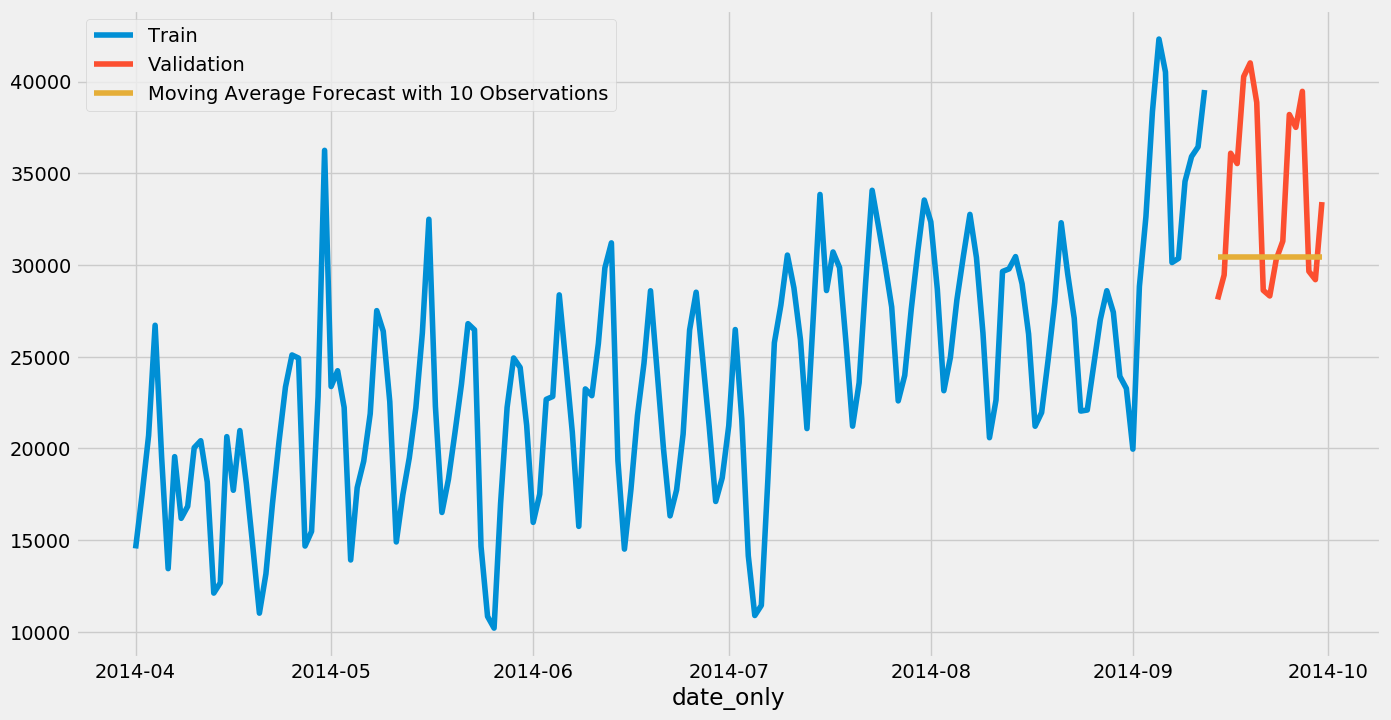

In [145]:
hat_avg = test_ts.copy()
hat_avg['moving_average_forecast'] = train_ts['date'].rolling(20).mean().iloc[-1]
plt.figure(figsize = (15,5))
train_ts['date'].plot(kind='line',figsize=(15,8), label = 'Train')
test_ts['date'].plot(kind='line', label = 'Validation')
plt.plot(hat_avg['moving_average_forecast'], label = 'Moving Average Forecast with 10 Observations')
plt.legend(loc = 'best')
plt.show()

In [147]:

rmse = np.sqrt(mean_squared_error(test_ts['date'], hat_avg['moving_average_forecast']))
rmse


5723.783176515748

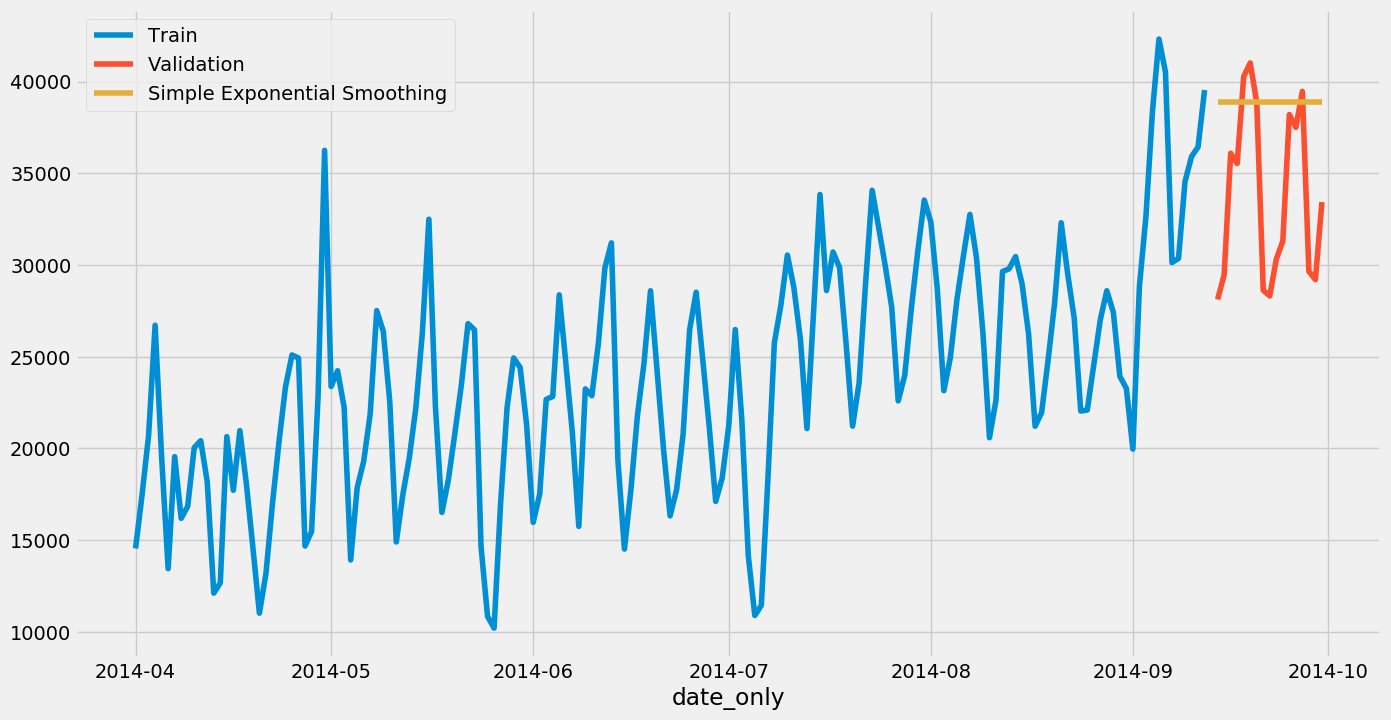

In [148]:
hat = test_ts.copy()
fit2 = SimpleExpSmoothing(np.asarray(train_ts['date'])).fit(smoothing_level = 0.8,optimized = False)
hat['SES'] = fit2.forecast(len(test_ts))
plt.figure(figsize =(15,8))
train_ts['date'].plot(kind='line',figsize=(15,8), label = 'Train')
test_ts['date'].plot(kind='line', label = 'Validation')
plt.plot(hat['SES'], label = 'Simple Exponential Smoothing')
plt.legend(loc = 'best')

error is till high.. let's see other model

## SARIMAX

In [151]:
def day_series_creator(dataframe):
    
    # Grouping by Date/Time to calculate number of trips
    day_df = pd.Series(dataframe.groupby(['date']).size())
    # setting Date/Time as index
    day_df.index = pd.DatetimeIndex(day_df.index)
    # Resampling to daily trips
    day_df = day_df.resample('1D').apply(np.sum)
    
    return day_df

In [152]:
day_df_2014 = day_series_creator(data)
day_df_2014.head()


date
2014-04-01    14546
2014-04-02    17474
2014-04-03    20701
2014-04-04    26714
2014-04-05    19521
Freq: D, dtype: int64

In [154]:
def initial_plots(time_series, num_lag):

    #Original timeseries plot
    plt.figure(1)
    plt.plot(time_series)
    plt.title('Original Uber data across time')
    plt.figure(2)
    plot_acf(time_series, lags = num_lag)
    plt.title('Autocorrelation plot')
    plot_pacf(time_series, lags = num_lag)
    plt.title('Partial autocorrelation plot')
    
    plt.show()

    
#Augmented Dickey-Fuller test for stationarity
#checking p-value
print('p-value: {}'.format(adfuller(day_df_2014)[1]))

p-value: 0.8458980824898367


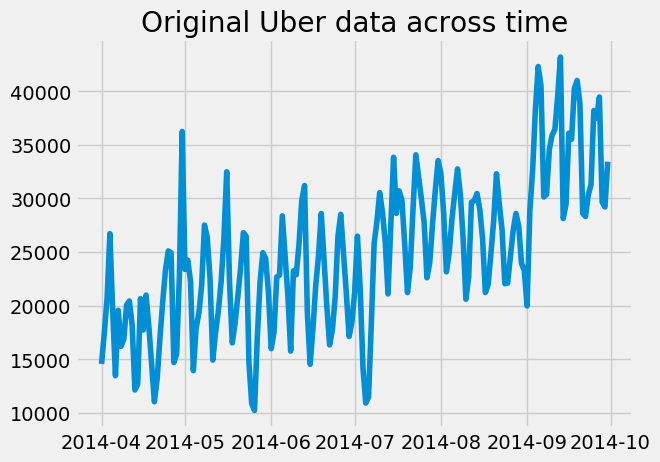

<Figure size 640x480 with 0 Axes>

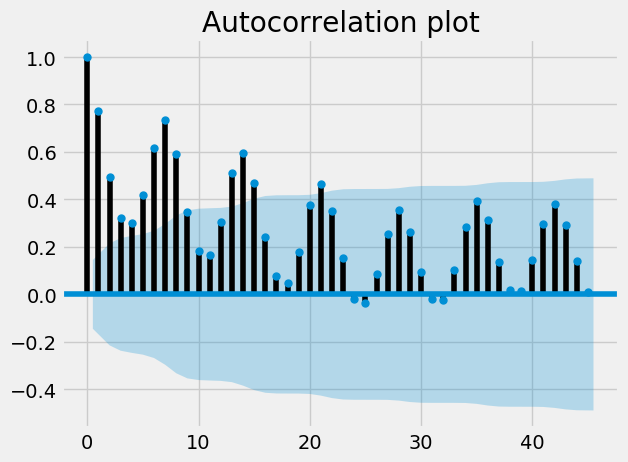

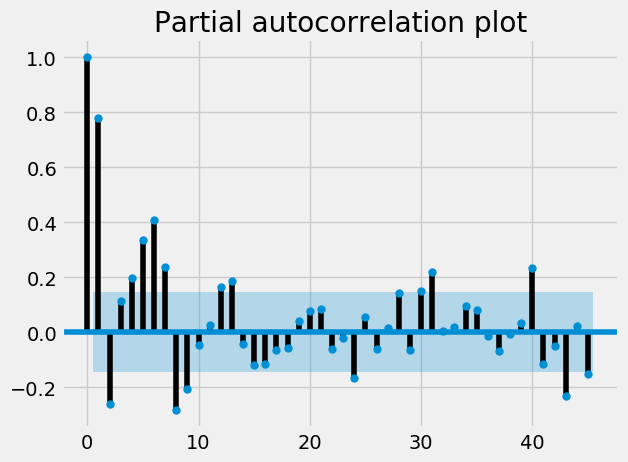

In [155]:

#plotting
initial_plots(day_df_2014, 45)

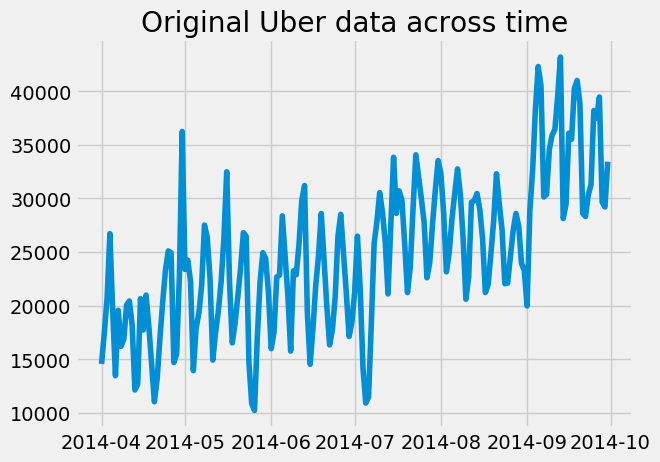

<Figure size 640x480 with 0 Axes>

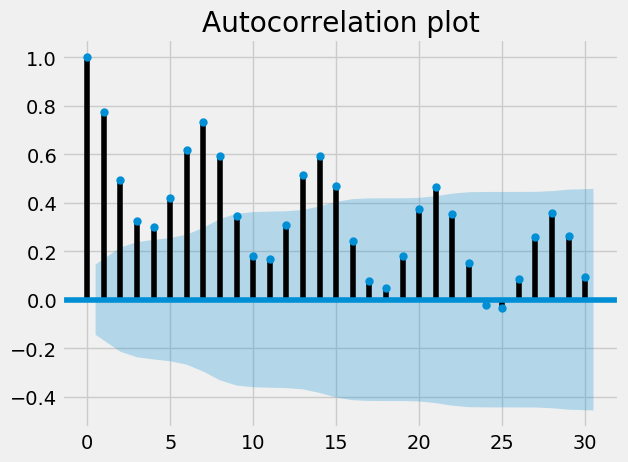

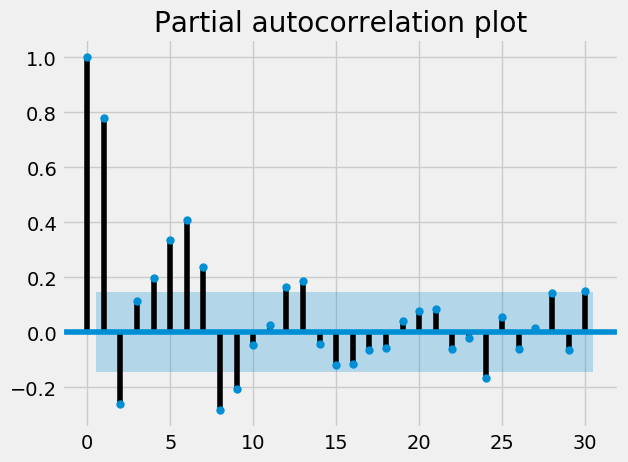

In [156]:
#plotting 30 observation
initial_plots(day_df_2014, 30)

In [157]:
diff_series = day_df_2014.diff(periods=1)

#Augmented Dickey-Fuller test for stationarity
#checking p-value
print('p-value: {}'.format(adfuller(diff_series.dropna())[1]))

p-value: 1.5163641177435566e-08


In [158]:
round(adfuller(diff_series.dropna())[1],2)

0.0

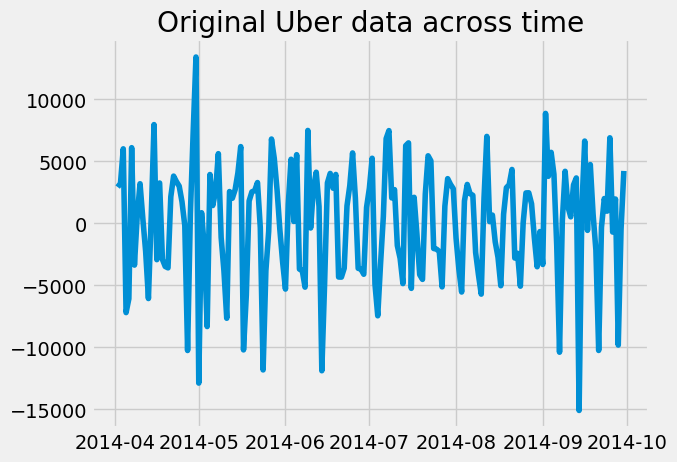

<Figure size 640x480 with 0 Axes>

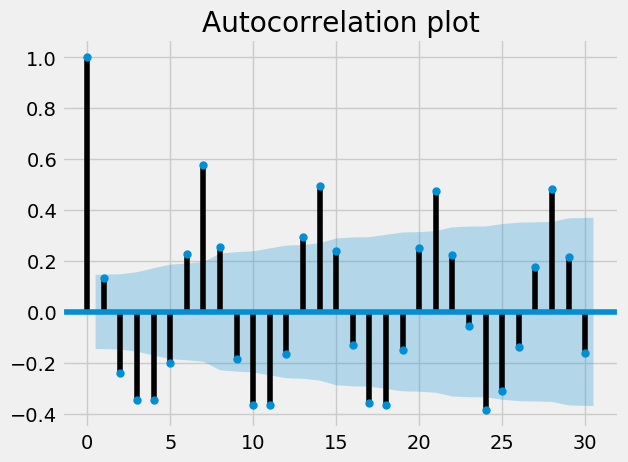

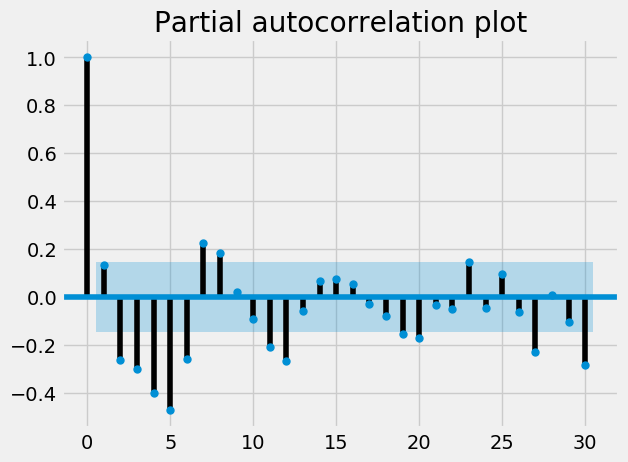

In [159]:

initial_plots(diff_series.dropna(), 30)

# ANN 

In [169]:
uber_count=data.groupby(pd.Grouper(key='date')).count()
print(uber_count.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260093 entries, 2014-04-01 00:11:00 to 2014-09-30 03:26:00
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   Date/Time      260093 non-null  int64
 1   Base           260093 non-null  int64
 2   date_only      260093 non-null  int64
 3   month          260093 non-null  int64
 4   dow_num        260093 non-null  int64
 5   dow_name       260093 non-null  int64
 6   month_day_num  260093 non-null  int64
 7   hours          260093 non-null  int64
dtypes: int64(8)
memory usage: 17.9 MB
None


In [171]:
uber_count.drop(['Base','date_only','month','dow_num','dow_name','month_day_num','hours'],axis=1,inplace=True)

In [172]:
uber_count

,Date/Time
date,
2014-04-01 00:11:00,6
2014-04-01 00:17:00,3
2014-04-01 00:21:00,5
2014-04-01 00:28:00,3
2014-04-01 00:33:00,5
...,...
2014-09-30 02:41:00,1
2014-09-30 02:59:00,1
2014-09-30 03:01:00,1


In [173]:
train = uber_count[:][:234084]             #90% of 260093
test = uber_count[:][234085:]

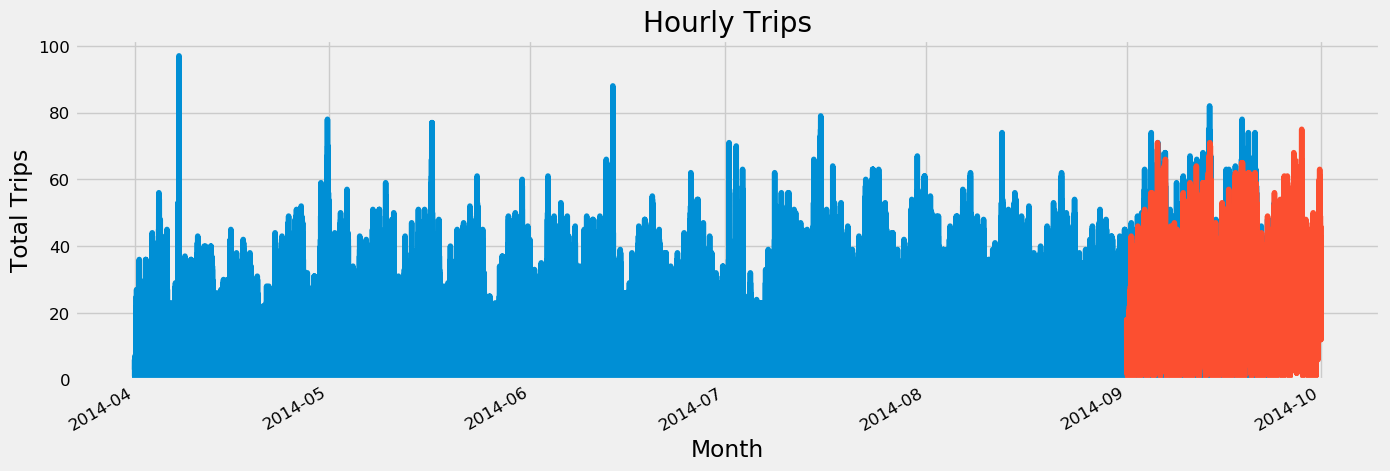

In [177]:
train['Date/Time'].plot(kind='area',figsize=(15,8), title= 'Hourly Trips', fontsize=14)
test['Date/Time'].plot(figsize=(15,5), title= 'Hourly Trips', fontsize=12)
plt.ylabel('Total Trips')
plt.xlabel('Month')
plt.show()

In [178]:

def test_stationary(timeseries):
    
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()
    
    
    #Plot rolling Statistics
    act = plt.plot(timeseries, color = "blue", label = "Actual")
    mean = plt.plot(rolmean, color = "brown", label = "Rolling Mean")
    std = plt.plot(rolstd, color = "black", label = "Rolling Std")
    plt.legend(loc = "best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.show(block = False)

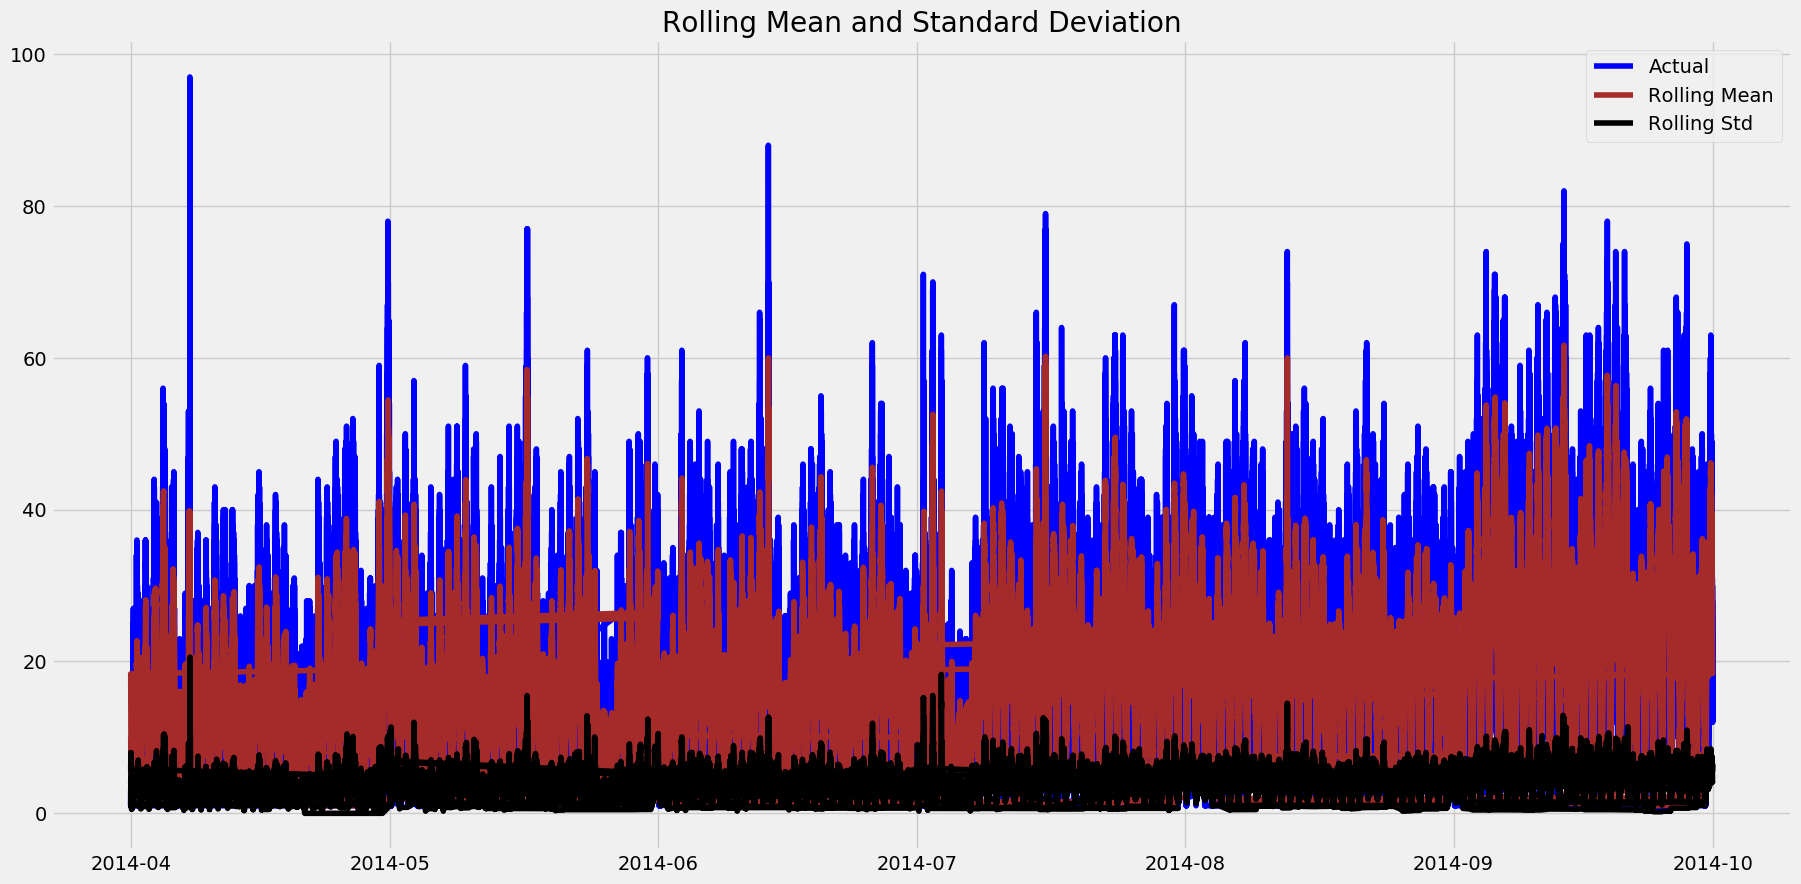

In [179]:
rcParams['figure.figsize']=(20,10)
test_stationary(uber_count['Date/Time'])

In [182]:
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [185]:

K.clear_session()

In [186]:
model = Sequential()
model.add(Dense(9, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)


Epoch 1/20
234083/234083 [==============================] - 353s 2ms/step - loss: 0.0028
Epoch 2/20
234083/234083 [==============================] - 356s 2ms/step - loss: 0.0029
Epoch 3/20
234083/234083 [==============================] - 374s 2ms/step - loss: 0.0029
Epoch 4/20
234083/234083 [==============================] - 2232s 10ms/step - loss: 0.0029
Epoch 5/20
234083/234083 [==============================] - 297s 1ms/step - loss: 0.0029
Epoch 6/20
234083/234083 [==============================] - 367s 2ms/step - loss: 0.0029
Epoch 00006: early stopping


In [188]:
y_pred_test_ann = model.predict(X_test)
y_train_pred_ann = model.predict(X_train)
rmse = sqrt(mean_squared_error(y_train,y_train_pred_ann))
print("Train : {:0.3f}".format(rmse))

rmse = sqrt(mean_squared_error(y_test,y_pred_test_ann))
print("Test : {:0.3f}".format(rmse))


Train : 0.089
Test : 0.093


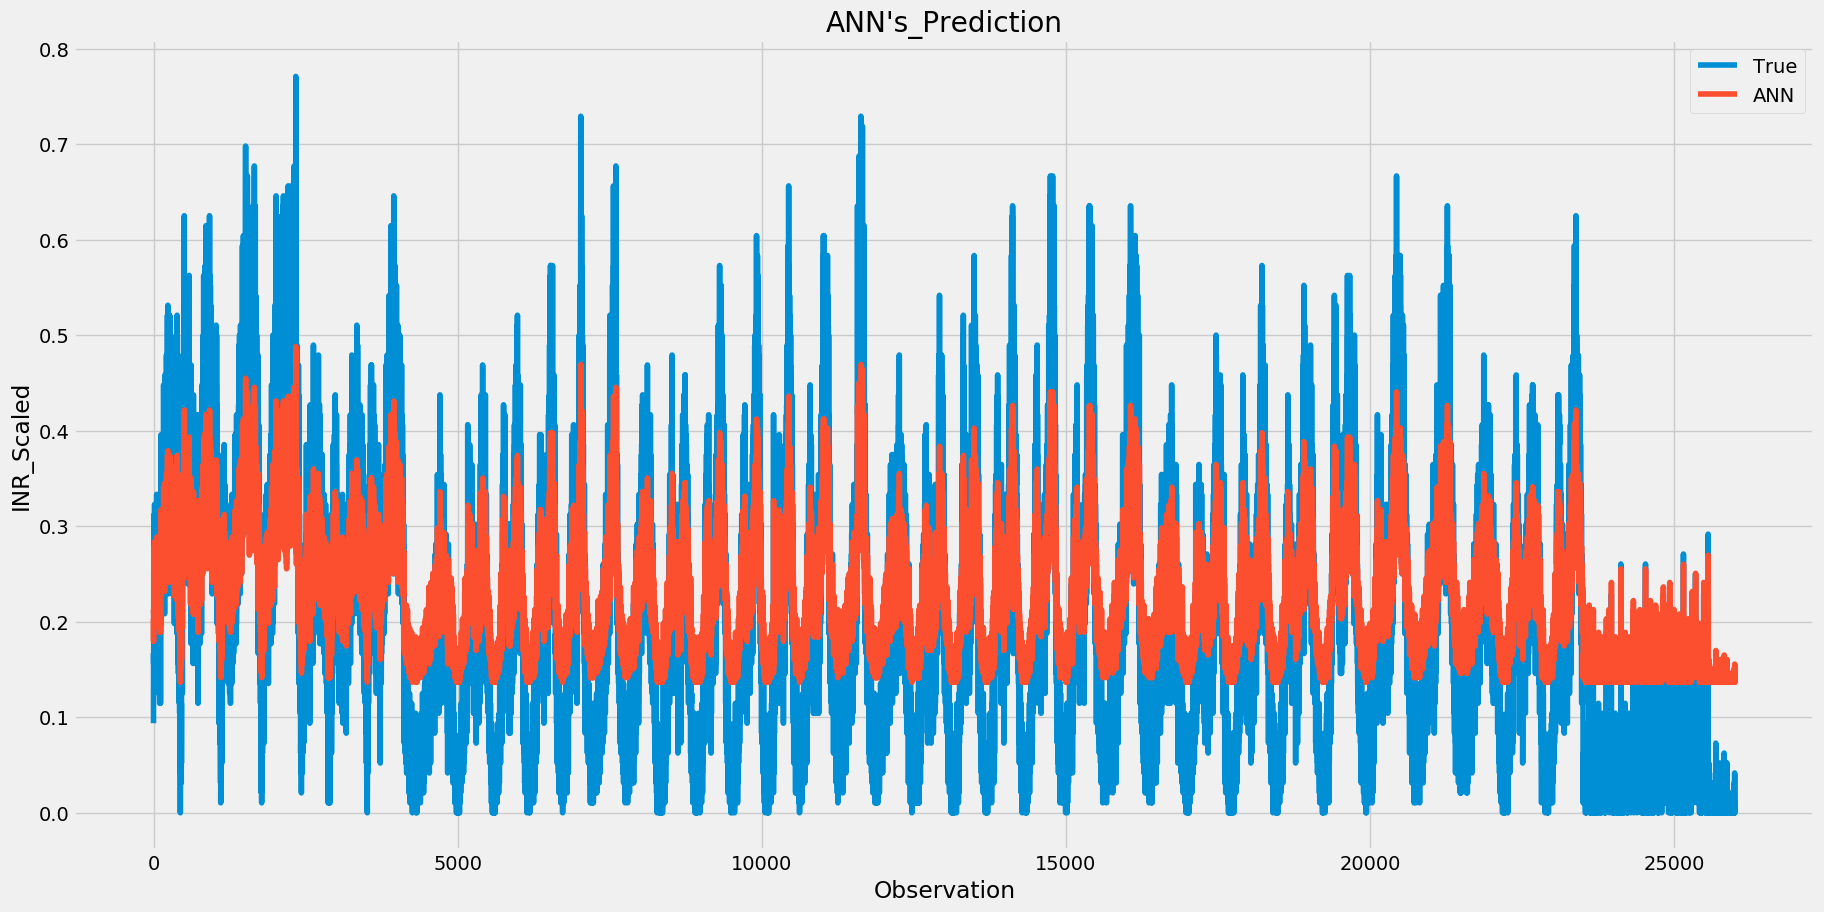

In [189]:
y_pred_test_ANN = model.predict(X_test)
plt.plot(y_test, label='True')
plt.plot(y_pred_test_ANN, label='ANN')
plt.title("ANN's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [190]:
from sklearn import metrics
acc=metrics.r2_score(y_test,y_pred_test_ann)
print("Accuracy Score of Model: ",round(acc*100,2),'%')

Accuracy Score of Model:  54.87 %


In [192]:

score_ann= model.evaluate(X_test, y_test, batch_size=1)
print('ANN: %f'%score_ann)

26007/26007 [==============================] - 21s 822us/step
ANN: 0.008619
